In [1]:
#@title Librerias
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.interpolate import CubicHermiteSpline
import sympy as sp
sp.init_printing()
import pandas as pd
import urllib.request
from math import factorial

# Actividad 05: Interpolación

---
### Profesor: Juan Marcos Marín
### Nombre: Sara Calle Muñoz
*Métodos computacionales 2025-I*

---

# 1
Supongamos que queremos interpolar la función  $f(x)=\sin(x)$  usando los puntos  $x_0=0$ ,  $x_1=\pi/2$ , y  $x_2=\pi$.

Encuentre el polinomio de interpolación de Lagrange y el error asociado al misma. Recuerde que el error de interpolación de Lagrange puede expresarse explícitamente como:

\begin{equation}
f(x) - P(x) = \epsilon = \frac{1}{(n+1)!} f^{(n+1)}(\xi)(x - x_0)(x - x_1) ... (x - x_n)
\end{equation}

Donde:
- $f^{(n+1)}(\xi)$ es la derivada de orden $n$ de la función $f(x)$ evaluada en algún punto $\xi$ en el intervalo de interpolación.

- Repita el numeral anterior, pero para los polinomios de interpolación de Hermite, conociendo que:


$$
f(x) - P(x) = \epsilon = \frac{f^{(2n+2)}(\xi)}{(2n+2)!} \prod_{i=0}^{n} (x - x_i)^2
$$

*Nota: recuerde que los indices en python inician en 0, luego si tenemos $n+1$ datos el polinomio es de orden $n$*

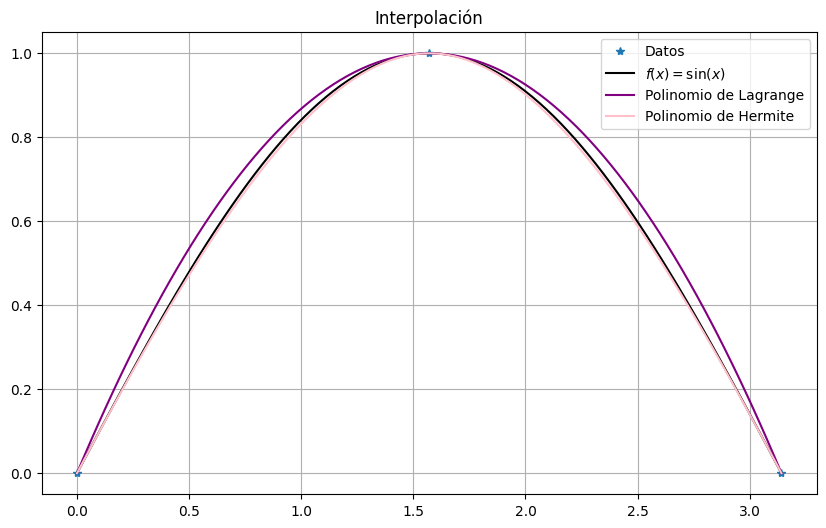

In [2]:
#definimos los valores
x = (0, np.pi/2, np.pi)
f = lambda x: np.sin(x)
y = f(x)

dy = np.cos(x) # derivada para Hermite
x_interp = np.linspace(min(x), max(x), 100) #puntos para interpolar

#polinomio de Lagrange y Hermite
P = lagrange(x, y)
Pol_Hermite = CubicHermiteSpline(x, y, dy) # Devuelve una función con el polinomio de Hermite

#gráficamos
plt.figure(figsize=(10, 6))
plt.plot(x, y, '*', label='Datos')
plt.plot(x_interp, f(x_interp), label='$f(x) = \\sin(x)$', color = 'black')
plt.plot(x_interp, P(x_interp), label='Polinomio de Lagrange', color ='purple')
plt.plot(x_interp, Pol_Hermite(x_interp), label='Polinomio de Hermite', color ='pink')
plt.title("Interpolación")
plt.legend()
plt.grid(True)
plt.show()

In [3]:
#esto fue para calcular las derivadas del error de Hermite
t = sp.symbols('t')
f = sp.sin(t)

df = sp.diff(f, t, 6)
df

-sin(t)

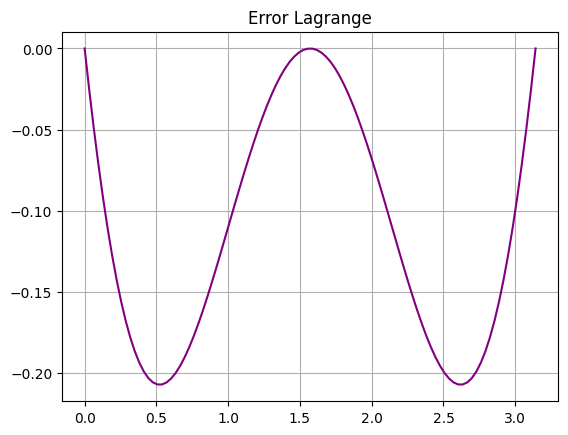

In [4]:
#para calcular el error del polinomio de Lagrange
Error_lagrange = lambda x: 1/factorial(3)*(-np.cos(x))*(x-0)*(x-np.pi/2)*(x-np.pi)

x = np.linspace(min(x_interp), max(x_interp), 100)

#gráficamos el error
plt.plot(x, Error_lagrange(x), color='purple')
plt.title("Error Lagrange")
plt.grid()

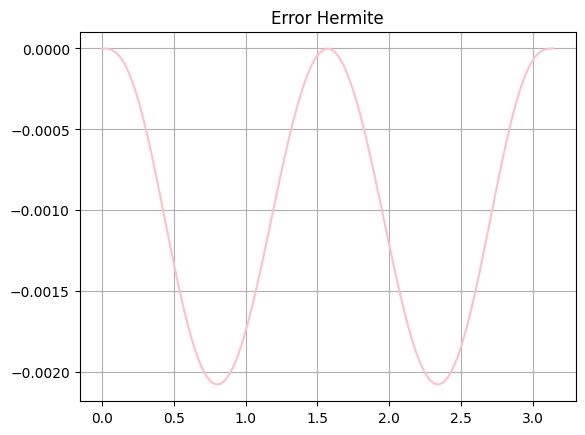

In [5]:
#para caluclar el error del polinomio de Hermite
Error_hermite= lambda x: 1/factorial(6)*(-np.sin(x))*((x-0)**2)*((x-np.pi/2)**2)*((x-np.pi)**2)
x = np.linspace(min(x_interp), max(x_interp), 100)

#gráficamos el error
plt.plot(x, Error_hermite(x), color='pink')
plt.title("Error Hermite")
plt.grid()

# 2

En física nuclear se calcula la sección eficaz de dispersión (scattering cross section) a partir de experimentos de colisiones, se sabe a partir de la teoría que la sección eficaz se describe por la formula de Breit-Wigner,

$$\sigma(E)=\frac{\sigma_0}{(E-E_r)^2+\frac{\Gamma^2}{4}}$$

donde $E$ es la energía y $E_r,\sigma_0, \Gamma$ son parámetros a ajustar; el valor predicho es $(E_r,\Gamma) = (78, 55)$ MeV; donde $\sigma_0$ se puede calcular ahora a partir de la fórmula simplemente remplazando cualquier par de puntos de la tabla.

A partir de los valores de energía,


```
Energia  = np.array([0   , 25  , 50  , 75  , 100 , 125 , 150 , 175 , 200])
sigma_exp= np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])

```

* Calcule los polinomios de Lagrange, Newton y Hermite.

* Haga un gráfico de los polinomios junto con la función original.

* Finalmente, a partir de la diferencia $|f(x) - P_n(x)|$ calcule el máximo   error asociado a cada uno de ellos. ¿Cuál será el mejor?

In [6]:
#datos
energia = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200])
sigma_exp = np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])

#parámetros de la función Breit-Wigner
Er = 78  # MeV
Gamma = 55  # MeV

#definimos la función
def breit_wigner(E, sigma0, Er=Er, Gamma=Gamma):
    return sigma0 / ((E - Er)**2 + (Gamma**2 / 4))

#puntos para encontrar sigma0
i = 3
E_i = energia[i]
sigma_i = sigma_exp[i]

#reemplazamos en la fórmula para calcular sigma0
sigma0 = sigma_i * ((E_i - Er)**2 + (Gamma**2 / 4))


In [7]:
# Polinomio de Lagrange
P_lagrange = lagrange(energia, sigma_exp)

# Polinomio de Hermite
dy = np.gradient(sigma_exp, energia)
Pol_Hermite = CubicHermiteSpline(energia, sigma_exp, dy)

# Para el polinomio de Newton (código tomado de las notas de clase)
def diferencia_dividida(x, y, i, j):
    '''
    Calcula recursivamente la diferencia dividida f[x_i, x_{i+1}, ..., x_j]
    Entradas:
      x: array de puntos x
      y: array de puntos y
      i: indice del primer punto
      j: indice del ultimo punto
    Salidas:
      a: coeficiente diferencia dividida (i,j)
    '''
    if i == j:
        return y[i]
    else:
        num = diferencia_dividida(x, y, i + 1, j) - diferencia_dividida(x, y, i, j - 1)
        den = x[j] - x[i]
        return num / den

def coeficientes_a(x, y):
    '''
    Calcula los coeficientes a_i del polinomio de Newton.
    Entradas:
      x: array de puntos x
      y: array de puntos y
    Salidas:
      coeficientes: array de coeficientes a_i
    '''
    n = len(x)
    coeficientes = np.zeros_like(x, dtype=float)
    for i in range(n):
        coeficientes[i] = diferencia_dividida(x, y, 0, i)
    return coeficientes
def Polinomio_Newton(x, y):
  '''
  Calcula el polinomio de Newton a partir de los puntos (x, y)
  Entradas:
    x: array de puntos x
    y: array de puntos y
  Salidas:
    P: polinomio de Newton como una función de x
  '''
  coef = coeficientes_a(x, y)
  def P(x_val):
    resultado = coef[0]
    producto = 1
    for i in range(1, len(x)):
      producto *= (x_val - x[i - 1])
      resultado += coef[i] * producto
    return resultado
  return P

P_newton = Polinomio_Newton(energia, sigma_exp)


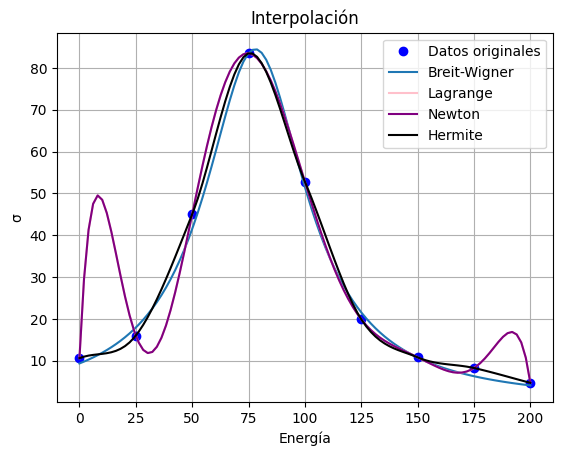

In [9]:
#evaluamos los polinomios
energia_interp = np.linspace(min(energia), max(energia), 100)
y_lagrange = P_lagrange(energia_interp)
y_newton = [P_newton(xi) for xi in energia_interp]
y_hermite = Pol_Hermite(energia_interp)

#gráficamos
plt.plot(energia, sigma_exp, 'bo', label='Datos originales')
plt.plot(energia_interp, breit_wigner(energia_interp, sigma0), label='Breit-Wigner')
plt.plot(energia_interp, y_lagrange, color='pink', label='Lagrange')
plt.plot(energia_interp, y_newton, color='purple', label='Newton')
plt.plot(energia_interp, y_hermite, color='black', label='Hermite')
plt.xlabel("Energía")
plt.ylabel("σ")
plt.title("Interpolación")
plt.grid(True)
plt.legend()
plt.show()


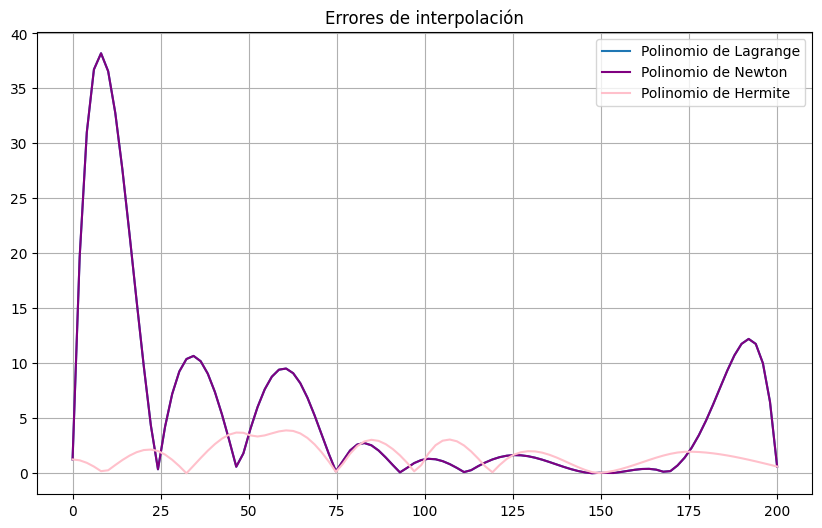

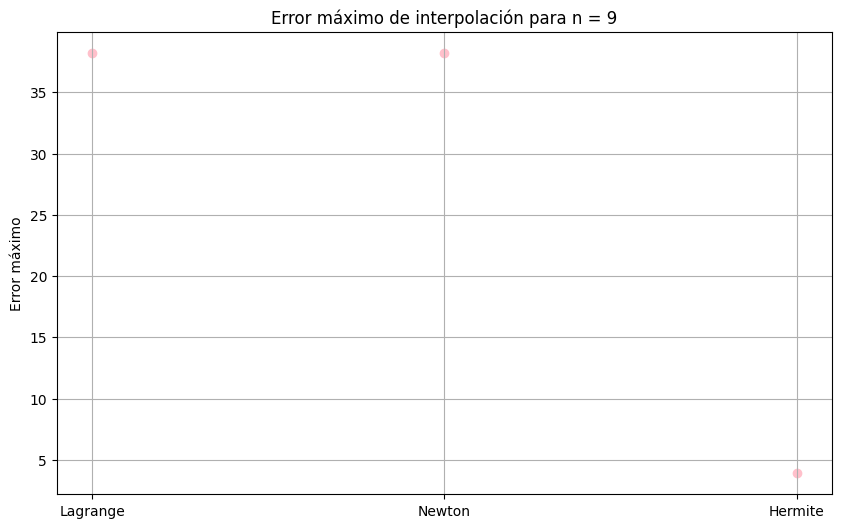

In [10]:
# Para las funciones de error (tomado de las notas de clase)
def Errores(x, f, f_interp):
    """
    Calcula el error absoluto entre la función original y la interpolada.
    Entradas:
    - x: puntos donde se evalúa la función
    - f: función original
    - f_interp: función interpolada
    Salida:
    - Errores absolutos en los puntos x
    """
    return np.abs(f(x) - f_interp(x))

# función original
f = lambda x: breit_wigner(energia_interp, sigma0)

# Definir errores para cada método de interpolación
Errores_Lagrange = Errores(energia_interp, f, P_lagrange)
Errores_n = Errores(energia_interp, f, P_newton)
Errores_Hermite = Errores(energia_interp, f, Pol_Hermite)

# Graficar errores
plt.figure(figsize=(10, 6))
plt.plot(energia_interp, Errores_Lagrange, label='Polinomio de Lagrange')
plt.plot(energia_interp, Errores_n, label='Polinomio de Newton', color = 'purple')
plt.plot(energia_interp, Errores_Hermite, label='Polinomio de Hermite', color = 'pink')
plt.title("Errores de interpolación")
plt.legend()
plt.grid(True)
plt.show()


# Error máximo
plt.figure(figsize=(10, 6))
plt.scatter(['Lagrange', 'Newton', 'Hermite'],
            [np.max(Errores_Lagrange),
             np.max(Errores_n), np.max(Errores_Hermite)],
            color='pink')
plt.title("Error máximo de interpolación para n = 9")
plt.ylabel("Error máximo")
plt.grid(True)
plt.show()

# 3
Consideremos la función:
\begin{equation*}
     f(x) = \frac{1}{1+25x^2}
\end{equation*}
en el intervalo $[-1, 1]$, definamos un conjunto de puntos $n+1$  equiespaciados en $[-1,1]$.

* Representar gráficamente la función junto al polinomio de interpolación de Lagrange, $p_n(x)$, para $n=\{ 4, 8, 12, 16, 20 \}$.
* Comprobar gráficamente cómo el error aumenta con $n$. Emplee la libreria, simbolica de `sympy` y encuente el error en la interpolación. La cota del  error , viene dado por:
\begin{equation}
f(x) - P(x) = \epsilon = \frac{1}{(n+1)!} f^{(n+1)}(\xi)(x - x_0)(x - x_1) ... (x - x_n)
\end{equation},

emplee la libreria simbólica para realizar la estimación de dicha cuota, sólo para $n = 4$, en el punto $x=0.5$.

* Repita la parte inicial para el conjunto de $p_n(x)$ con $n=\{ 4, 8, 12, 16, 20 \}$, usando la interpolación de Hermite, ¿existe alguna diferencia?

* Usando los datos del numeral anterior ahora usando el método `CubicSpline` realiza la interpolación y concluya.

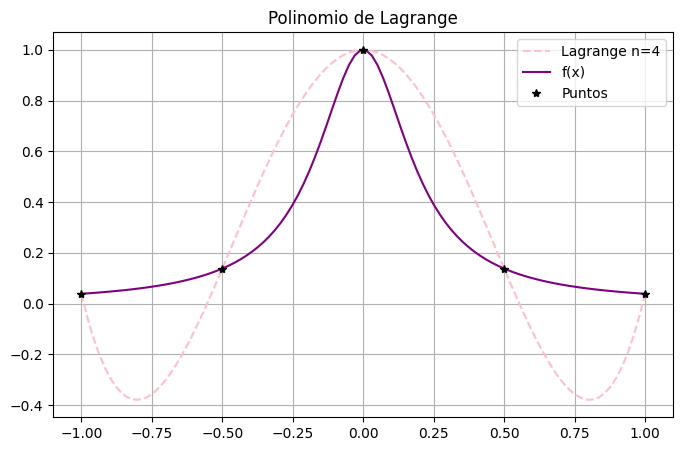

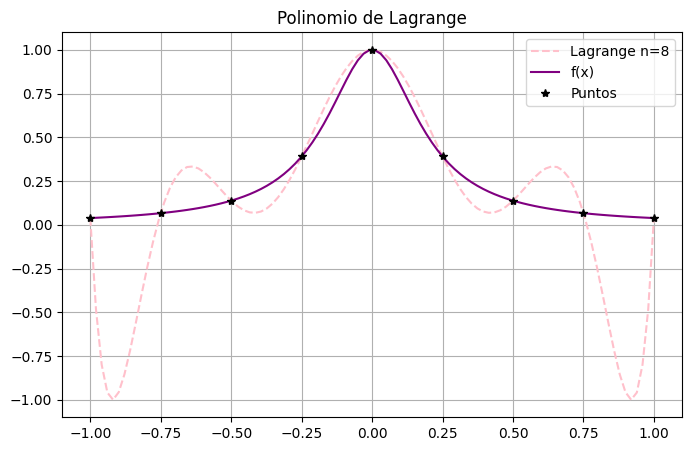

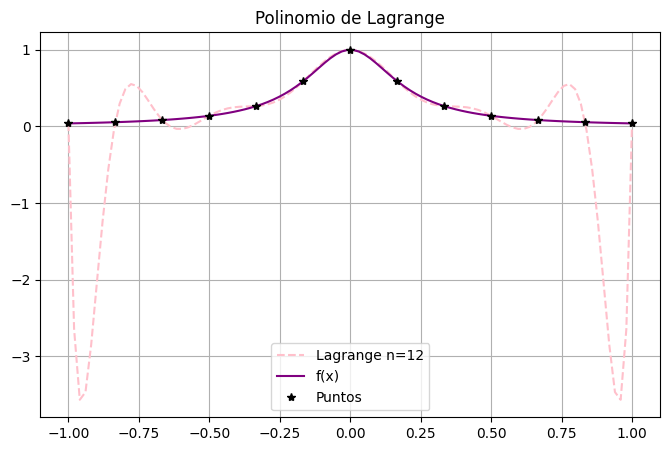

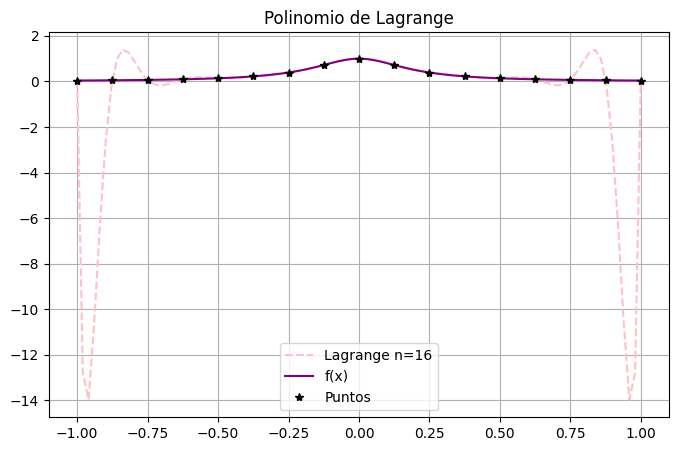

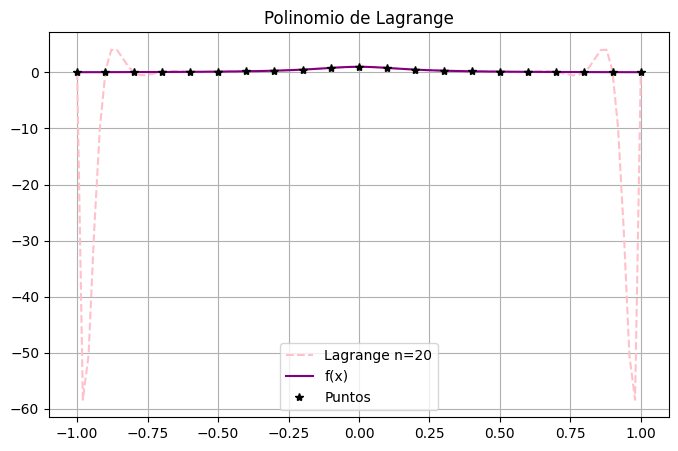

In [12]:
# Definimos la función
f = lambda x: 1 / (1 + 25 * x**2)

# Valores de n y x para la interpolación
n_vals = [4, 8, 12, 16, 20]
x_vals = np.linspace(-1, 1, 1000)
x_interp = np.linspace(min(x_vals), max(x_vals), 100)

for N in n_vals:
    x_n = np.linspace(-1, 1, N + 1)
    pol_lagrange = lagrange(x_n, f(x_n))
    plt.figure(figsize=(8, 5))
    plt.plot(x_interp, pol_lagrange(x_interp), color='pink', label=f"Lagrange n={N}", linestyle= '--')
    plt.plot(x_interp, f(x_interp), label="f(x)", color = 'purple')
    plt.plot(x_n, f(x_n), 'k*', label='Puntos')
    plt.legend()
    plt.title("Polinomio de Lagrange")
    plt.grid(True)
    plt.show()

In [14]:
#para el error de Lagrange
t = sp.symbols('t')
f_sym = 1 / (1 + 25*t**2)

#derivada de orden 5
f5 = sp.diff(f_sym, t, 5)
f5_func = sp.lambdify(t, f5)

#valores para n = 4
n = 4
x_n = np.linspace(-1, 1, n + 1)
x_eval = 0.5

#evaluamos el producto
prod_term = 1
for xi in x_n:
    prod_term *= (x_eval - xi)

#estimamos la cota del error
t_vals = np.linspace(-1, 1, 1000)
max_f5 = np.max(np.abs(f5_func(t_vals)))

#cota de error
error = (1 / factorial(n + 1)) * max_f5 * np.abs(prod_term)
print(f"Cota del error para n=4 en x=0.5: {error:.10e}")

Cota del error para n=4 en x=0.5: 0.0000000000e+00


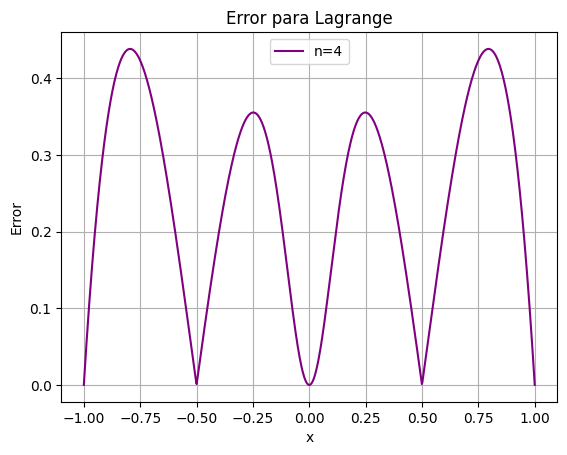

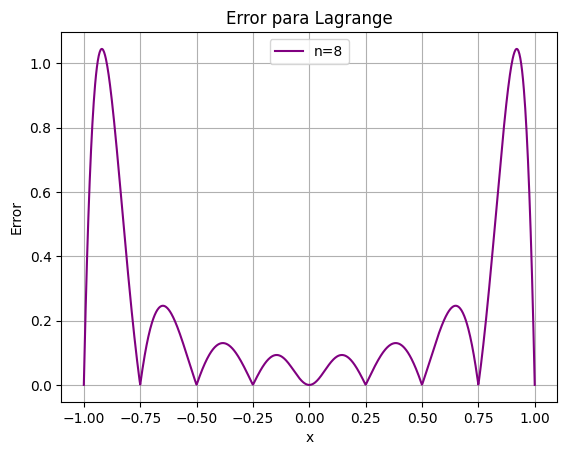

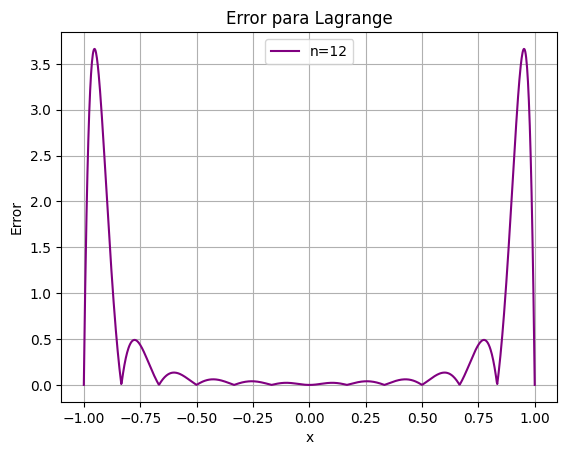

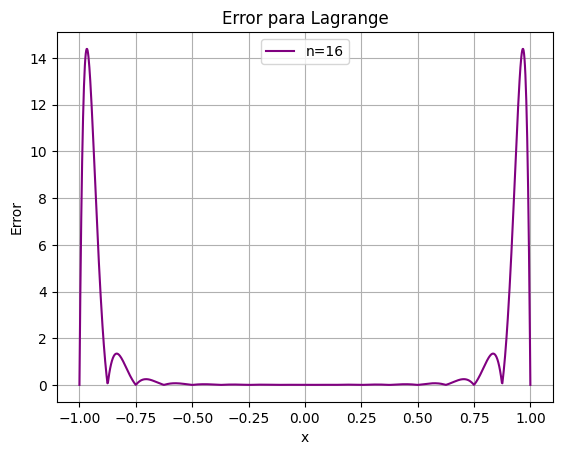

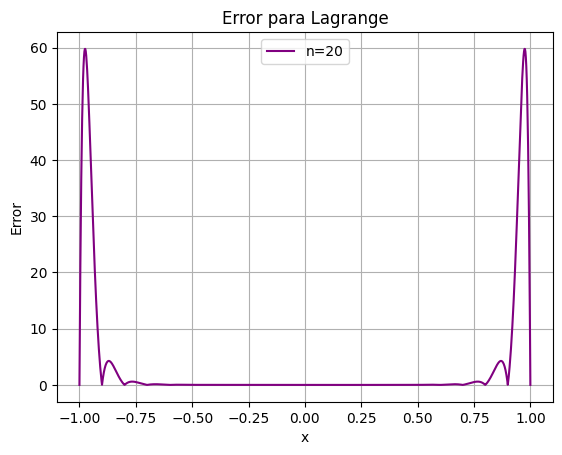

In [16]:
#para gráficar el error de Lagrange para distintos n
f = lambda x: 1 / (1 + 25 * x**2)
x_vals = np.linspace(-1, 1, 1000)
n_vals = [4, 8, 12, 16, 20]

for N in n_vals:
    x_n = np.linspace(-1, 1, N + 1)
    pol = lagrange(x_n, f(x_n))
    y_interp = pol(x_vals)
    y = f(x_vals)
    error = np.abs(y - y_interp)
    plt.plot(x_vals, error, label=f'n={N}', color='purple')
    plt.title("Error para Lagrange")
    plt.xlabel("x")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.show()

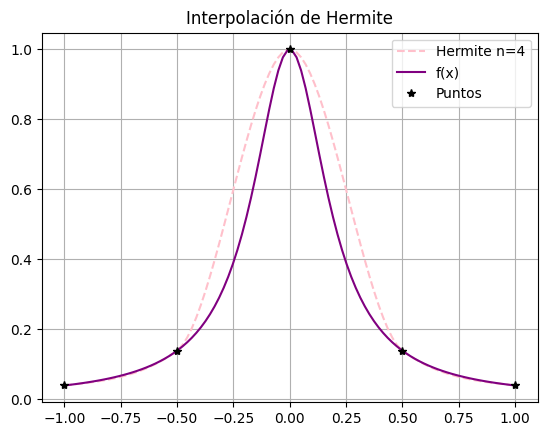

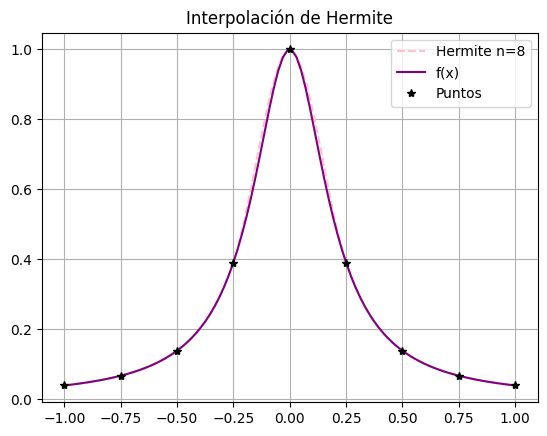

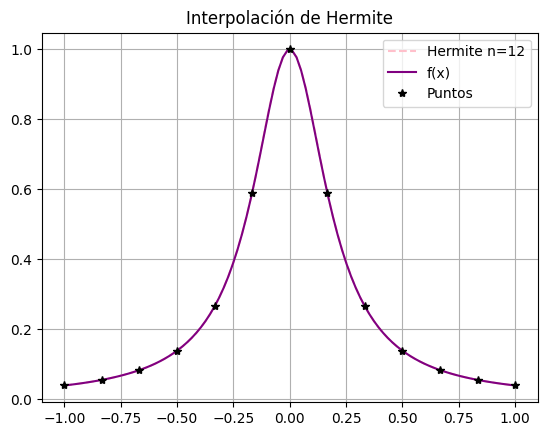

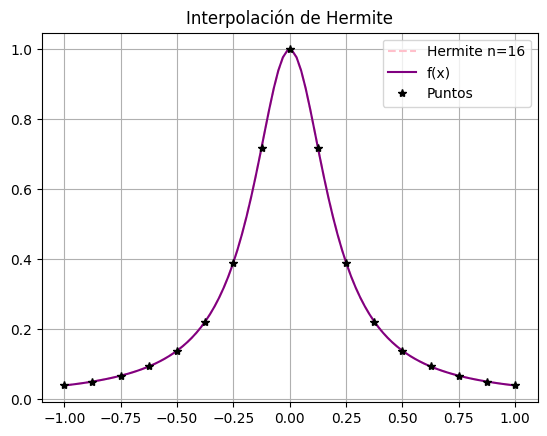

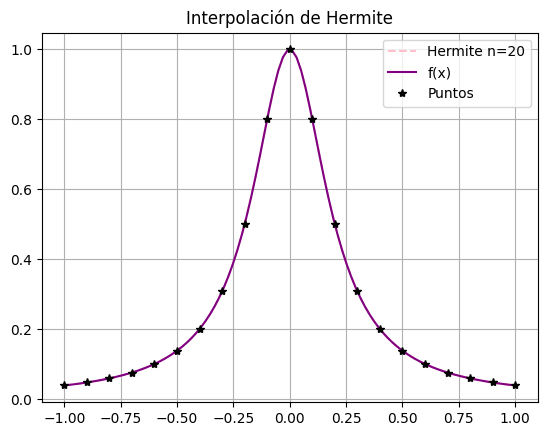

In [17]:
#para la interpolación con Hermite
f = lambda x: 1 / (1 + 25 * x**2)
x_vals = np.linspace(-1, 1, 1000)
n_vals = [4, 8, 12, 16, 20]
x_interp = np.linspace(min(x_vals), max(x_vals), 100)

#para calcular la derivada
t = sp.symbols('t')
f_sym = 1 / (1 + 25*t**2)
df_sym = sp.diff(f_sym, t)
df_n = sp.lambdify(t, df_sym)

for N in n_vals:
    x_n = np.linspace(-1, 1, N + 1)
    y_n = f(x_n)
    dy_n = df_n(x_n)
    Pol_Hermite = CubicHermiteSpline(x_n, y_n, dy_n)
    plt.plot(x_interp, Pol_Hermite(x_interp), label=f"Hermite n={N}", color='pink', linestyle='--')
    plt.plot(x_interp, f(x_interp), label="f(x)", color='purple')
    plt.title("Interpolación de Hermite")
    plt.plot(x_n, f(x_n), 'k*', label='Puntos')
    plt.legend()
    plt.grid(True)
    plt.show()

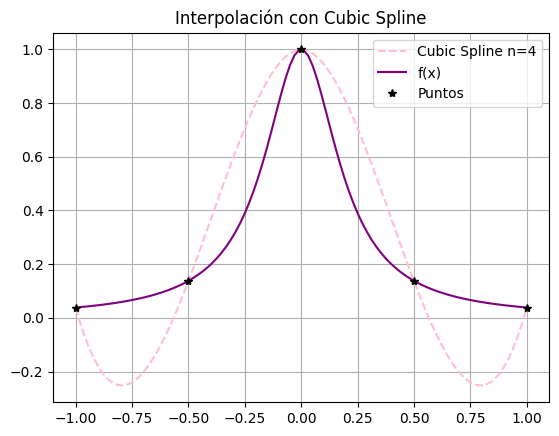

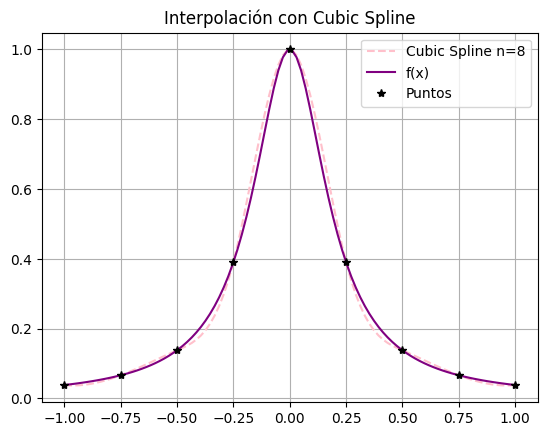

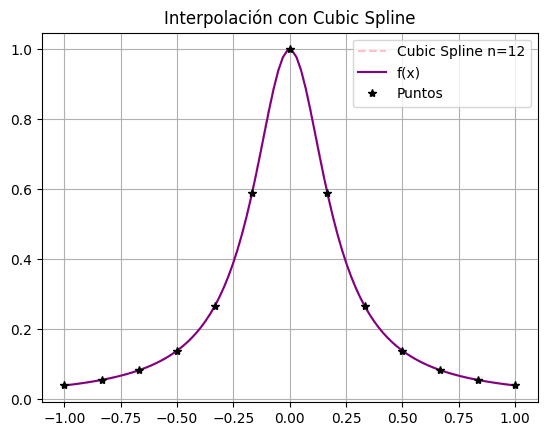

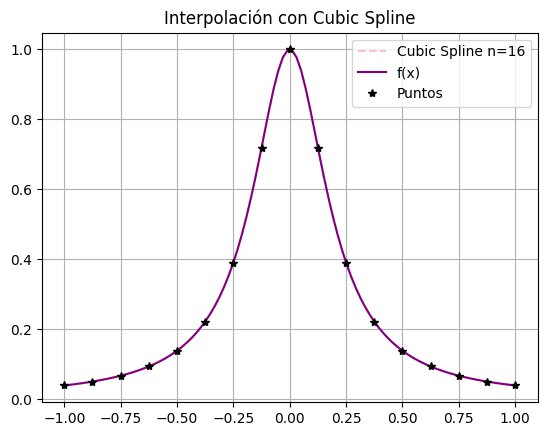

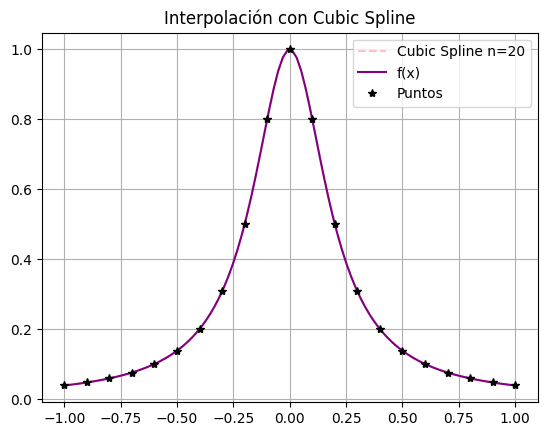

In [18]:
#para la interpolación con CubicSpline
f = lambda x: 1 / (1 + 25 * x**2)
x_vals = np.linspace(-1, 1, 1000)
n_vals = [4, 8, 12, 16, 20]
x_interp = np.linspace(min(x_vals), max(x_vals), 100)

for N in n_vals:
    x_n = np.linspace(-1, 1, N + 1)
    y_n = f(x_n)
    dy_n = df_n(x_n)
    Pol_cubic = CubicSpline(x_n, y_n)
    plt.plot(x_interp, Pol_cubic(x_interp), label=f"Cubic Spline n={N}", color='pink', linestyle='--')
    plt.plot(x_interp, f(x_interp), label="f(x)", color='purple')
    plt.plot(x_n, f(x_n), 'k*', label='Puntos')
    plt.title("Interpolación con Cubic Spline")
    plt.legend()
    plt.grid(True)
    plt.show()

Al interpolar la función usando los tres métodos, observamos que los polinomios de Lagrange con muchos puntos tiende fallar cerca de los bordes por el fenómeno de Runge, la interpolación de Hermite mejora considerablemente al igual que el método de Cubic Spline, nos dan una curva más precisa por lo que serían la mejor opción para interpolar.

# 4

Consideremos la imagen ![paloma](https://github.com/hernansalinas/autogrades/blob/main/Laboratorios_Taller/img/paloma.png?raw=true).

Ref: Metodos numericos, Burden.


Con los datos dados en la tabla:

1. Representar gráficamente la imagen, usando las órdenes `imread` e `imshow` de python (estas órdenes están contenidas en el paquete `matplotlib`)

2. Definir una lista de puntos, $x_i$,$y_i$ del pato y realice una interpolación lineal entre los mismos.

3. Representar el polinomio de interpolación de Lagrange en estos puntos, para aproximar el dibujo.

4. Repetir el proceso de interpolación mediante *splines* cúbicos. Para ello, utilizar la función `CubicSpline` (contenida en `scipy.interpolate`),


5. Comparar los resultados. ¿Alguna de las interpolaciones presenta oscilaciones? ¿A qué se debe este fenómeno?

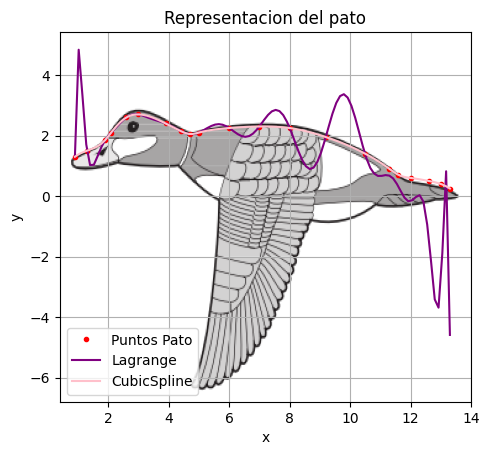

In [19]:
pato = 'https://3.bp.blogspot.com/-8_LTrCIxVSQ/VxU-5Gq2ffI/AAAAAAAAIto/LhCDEwHKTiAbLr7IhizQwGV13YTwgpbDwCLcB/s400/pato1.png' #URL
urllib.request.urlretrieve(pato, 'pato.jpg')# Decargar la imagen
imagen_pato = plt.imread('pato.jpg') # Variable con la imagen del pato

# Definimos los puntos del pato
xp = [0.9, 1.3, 1.9, 2.1, 2.6, 3.0, 3.9, 4.4, 4.7, 5.0, 6.0, 7.0, 8.0, 9.2, 10.5, 11.3, 11.6, 12.0, 12.6, 13.0, 13.3]
yp = [1.3, 1.5, 1.85, 2.1, 2.6, 2.7, 2.4, 2.15, 2.05, 2.1, 2.25, 2.3, 2.25, 1.95, 1.4, 0.9, 0.7, 0.6, 0.5, 0.4, 0.25]
x1 = np.linspace(0.9,13.3,100)

PL = lagrange(xp,yp) # Calculamos el polinomio de Lagrange
cs = CubicSpline(xp,yp) # Calculamos el polinomio para CubicSpline

# Representamos graficamente al pato y los puntos que definimos para su contorno superior
plt.figure()
plt.title('Representacion del pato')
plt.imshow(imagen_pato, extent = (0.4, 14, -6.8, 3.45)) # Ajustamos los pixeles para que coincidan con x e y
plt.plot(xp, yp, '.r', label = 'Puntos Pato')
plt.plot(x1,PL(x1), label="Lagrange", color = 'purple')
plt.plot(x1,cs(x1), label="CubicSpline", color = 'pink')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

Podemos observar que la interpolación con CubicSpline nos da una muy buena aproximación a la silueta del pato, mientras que la interpolación de Lagrange presenta varias oscilaciones, que se deben al "fenómeno de Runge" (Visto en las notas de clase), este se presenta cuando intentamos ajustar una función con un polinomio de un grado alto en un intervalo cerrado usando puntos equidistantes (conforme aumenta el grado del polinomio también aumentan las oscilaciones).

# 5

Calcular el spline cúbico que interpola los puntos $(-1,5)$, $(0,3)$, $(1,3)$, $(2,4)$, para esto escriba la matriz asociada y encuentre los polinomios $S_0(x)$, $S_1(x)$ y $S_2(x)$. Evalue su respuesta para $x= 1.5$ usando `CubicSpline` de `scipy`.

In [20]:
from numpy.linalg import solve

In [21]:
x0, x1, x2, x3 = -1, 0, 1, 2
y0, y1, y2, y3 =  5, 3, 3, 4

x_points = np.array([-1, 0, 1, 2])
y_points = np.array([5, 3, 3, 4])

Para calcular los splines cúbicos debemos resolver el sistema de ecuaciones que define los coeficientes de los polinomios cúbicos en los subintervalos $[-1,0]$, $[0,1]$, $[1,2]$. Empleando las condiciones del metodo de spline, y defiendo los polinomios para garantizar la continuidad en cada unos de los puntos, tenemos que:

Tenemos que:
  * $s_0(x) = a_0 + b_0 (x-x_0) + c_0 (x-x_0)^2 + d_0 (x-x_0)^3$,
  * $s_1(x) = a_1 + b_1 (x-x_1) + c_1 (x-x_1)^2 + d_1 (x-x_1)^3$,
  * $s_2(x) = a_2 + b_2 (x-x_2) + c_2 (x-x_2)^2 + d_2 (x-x_2)^3$.

Reemplazando los puntos obtenemos:
  * $s_0(x) = a_0 + b_0 (x+1) + c_0 (x+1)^2 + d_0 (x+1)^3$,
  * $s_1(x) = a_1 + b_1 x + c_1 x^2 + d_1 x^3$.
  * $s_2(x) = a_2 + b_2 (x-1) + c_2 (x-1)^2 + d_2 (x-1)^3$

Calculamos las primeras derivadas:
  * $s_0'(x) =  b_0 + 2 c_0 (x+1) + 3 d_0 (x+1)^2$
  * $s_1'(x) =  b_1 + 2 c_1 x + 3 d_1 x^2$
  * $s_2'(x) = b_2 + 2 c_2(x-1) + 3 d_2 (x-1)^2$

Calculamos las segundas derivadas:
* $s_0''(x) = 2 c_0 + 6 d_0 (x+1)$
* $s_1''(x) = 2 c_1 + 6 d_1 x$
* $s_2''(x) = 2c_2 + 6d_2(x-1)$

Ahora debemos cumplir las condiciones del Spline cúbico
* Condición de interpolación:

  * $s_0(-1) = 5$, es decir, $a_0=5$.
  * $s_0(0)  = 3$, es decir, $a_0+b_0+c_0+d_0=3$.
  * $s_1(0) = 3$, es decir, $a_1=3$.
  * $s_1(1)  = 3$, es decir, $a_1+b_1+c_1+d_1=3$.
  * $s_2(1) = 3$, es decir, $a_2 = 3$
  * $s_2(2) = 4$, es decir, $a_2 + b_2 +c_2 +d_2 = 4$

* Condición de la primera derivada:

  * $s_0'(0) = s_1'(0)$, es decir, $b_0+2c_0+3d_0 = b_1$.
  * $s_1'(1) = s_2'(1)$, es decir, $b_1 + 2c_1 + 3d_1 = b_2$

* Condición de la segunda derivada:

  * $s_0''(0) = s_1''(0)$, es decir, $2c_0+6d_0 = 2c_1$.
  * $s_1''(1) = s_2''(1)$, es decir, $c_1 + 3d_1 = c_2$

* Condiciones de frontera (las segundas derivadas en los extremos son cero):

  * $s_0''(-1) = 0$, es decir, $2c_0=0$.
  * $s_2''(2) = 0$, o sea $2c_2 + 6d_2=0$.

Observe que obtuvimos directamente los valores $a_0$, $a_1$, $a_2$ y $c_0$.


In [22]:
# definimos los coeficientes obtenidos
a0 = 5
a1 = 3
a2 = 3
c0 = 0

Ahora note que tenemos un sistema de 8 ecuaciones 8 incógnitas ($b_0$, $b_1$, $b_2$, $c_1$, $c_2$, $d_0$, $d_1$, $d_2$), reemplazando los coeficientes obtenidos tenemos:

 * $b_0 + d_0 = -2$,
 * $b_1+c_1+d_1=0$,
 * $b_2 +c_2 +d_2 = 1$,
 * $b_0 + 3d_0 -b_1 = 0$
 * $b_1 + 2c_1 + 3d_1 -b_2 = 0$
 * $3d_0-c_1=0$
 * $c_1 + 3d_1 -c_2 = 0$
 * $c_2 + 3d_2 = 0$

La matriz asociada al sistema de ecuaciones es:


In [23]:
A = np.array([
  [1, 1, 0, 0, 0, 0, 0, 0],   # b_0 + d_0 = -2
  [0, 0, 1, 1, 1, 0, 0, 0],   # b_1 + c_1 + d_1 = 0
  [0, 0, 0, 0, 0, 1, 1, 1],   # b_2 + c_2 + d_2 = 1
  [1, 3, -1, 0, 0, 0, 0, 0],  # b_0 + 3d_0 - b_1 = 0
  [0, 0, 1, 2, 3, -1, 0, 0],  # b_1 + 2c_1 + 3d_1 - b_2 = 0
  [0, 3, 0, -1, 0, 0, 0, 0],  # 3d_0 - c_1 = 0
  [0, 0, 0, 1, 3, 0, -1, 0],  # c_1 + 3d_1 - c_2 = 0
  [0, 0, 0, 0, 0, 0, 1, 3]    # c_2 + 3d_2 = 0
])

b = np.array([-2, 0, 1, 0, 0, 0, 0, 0])

In [24]:
# Resolvemos el sistema de ecuaciones asociado
sol = solve(A,b)

# Definimos la solución como variables b0, d0, b1, c1, d1, b2, c2 y d2
b0,d0,b1,c1,d1,b2,c2,d2 = sol
sol

array([-2.46666667,  0.46666667, -1.06666667,  1.4       , -0.33333333,
        0.73333333,  0.4       , -0.13333333])

In [25]:
#veamos los polinomios de interpolación S_0(x)
x = sp.symbols('x')
x0, x1, x2 = -1, 0, 1

S0 = a0 + b0*(x-x0) + c0*(x-x0)**2 + d0*(x-x0)**3
sp.expand(S0)

                   3        2                           
0.466666666666667⋅x  + 1.4⋅x  - 1.06666666666667⋅x + 3.0

In [26]:
S1 = a1 + b1*(x-x1) + c1*(x-x1)**2 + d1*(x-x1)**3
sp.expand(S1)

                     3        2                         
- 0.333333333333333⋅x  + 1.4⋅x  - 1.06666666666667⋅x + 3

In [27]:
S2 = a2 + b2*(x-x2) + c2*(x-x2)**2 + d2*(x-x2)**3
sp.expand(S2)

                     3        2                            
- 0.133333333333333⋅x  + 0.8⋅x  - 0.466666666666667⋅x + 2.8

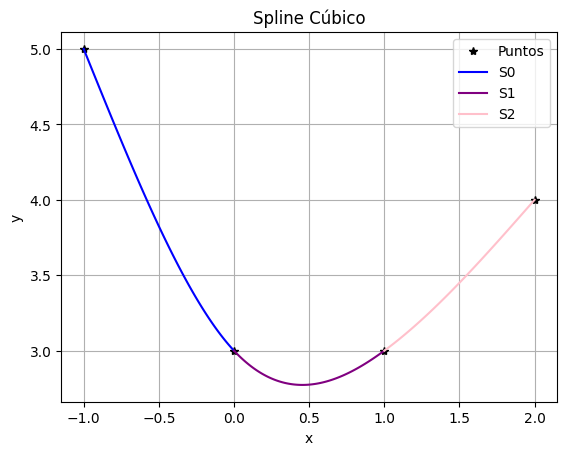

In [28]:
#como funciones 'numpy' para graficación
s0 = sp.lambdify(x, S0)
s1 = sp.lambdify(x, S1)
s2 = sp.lambdify(x, S2)

x_0 = np.linspace(x_points[0], x_points[1], 100)
x_1 = np.linspace(x_points[1], x_points[2], 100)
x_2 = np.linspace(x_points[2], x_points[3], 100)

plt.plot(x_points, y_points, 'k*', label = 'Puntos')
plt.plot(x_0, s0(x_0), label = 'S0', color ='blue')
plt.plot(x_1, s1(x_1), label = 'S1', color ='purple')
plt.plot(x_2, s2(x_2), label = 'S2', color ='pink')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Spline Cúbico')
plt.legend()
plt.grid()
plt.show()


In [29]:
#usamos scipy para comparar y evaluar en x = 1.5
cs = CubicSpline(x_points, y_points)
x_val = 1.5
y_val = cs(x_val)

#con el spline calculado
resultado = s2(x_val)

print(f"Con el spline calculado en x = {x_val}: {resultado}")
print(f"Con el Spline evaluado con scipy en x = {x_val}: {y_val}")


Con el spline calculado en x = 1.5: 3.450000000000003
Con el Spline evaluado con scipy en x = 1.5: 3.4375
